# Video Anomaly Detection Using Spatio-Temporal AutoEncoder

# Loading the Dataset
Before starting off, we must upload a `kaggle.json` file containing an api-key generated through the user profile on Kaggle. This will help us import the challenge's dataset on Google Colab directly from Kaggle.

In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install kaggle

In [ ]:
!kaggle competitions download -c pixel-play-26

100% 2.48G/2.49G [01:39<00:00, 12.4MB/s]
100% 2.49G/2.49G [01:39<00:00, 26.8MB/s]


In [ ]:
!unzip pixel-play-26.zip

Streaming output truncated to the last 5000 lines.
  inflating: Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos/07/frame_00696.jpg  
  inflating: Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos/07/frame_00697.jpg  
  inflating: Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos/07/frame_00698.jpg  
  inflating: Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos/07/frame_00699.jpg  
  inflating: Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos/07/frame_00700.jpg  
  inflating: Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos/07/frame_00701.jpg  
  inflating: Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos/07/frame_00702.jpg  
  inflating: Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos/07/frame_00703.jpg  
  inflating: Avenue_Corrupted

In [3]:
# Importing PyTorch and some other utilities

import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import transforms

## Data Handling
The class below will used later to randomly tilt and or blur images based on a small probability during data transformation.
    
- Gaussian Blur (Simulates focus issues and motion blur)
- Random Rotation (Simulates camera shake/tilt)

In [6]:
class ConsistentVideoAugment:

    # blur_p is the probability that the frame will be blurred
    # rotate_p is the probability that the frame will be rotated
    def __init__(self, image_size=128, blur_p=0.2, rotate_p=0.3, rotate_degrees=2.0):
        self.image_size = image_size
        self.blur_p = blur_p
        self.degrees = rotate_degrees
        self.rotate_p = rotate_p

    def __call__(self, frames):
        # frames: List of PIL Images (Grayscale 'L')
        # Returns a tensor of shape (1, T, H, W) normalized to 0-1
        # T is the number of frames in the clip

        # Determine parameters once per clip based

        apply_blur = random.random() < self.blur_p

        # Select a random angle between -degrees and +degrees
        if random.random() < self.rotate_p:
            angle = random.uniform(-self.degrees, self.degrees)
        else:
            angle = 0.0

        processed_frames = []

        for img in frames:
            # Resize image to 128x128
            img = TF.resize(img, (self.image_size, self.image_size))

            # Apply Rotation
            # expand=False keeps the image size same, cropping the corners slightly
            # fill=0 fills corners with black (model learns to ignore edges)
            if self.degrees > 0:
                img = TF.rotate(img, angle, expand=False, fill=0)

            # Apply Gaussian Blur
            if apply_blur:
                img = TF.gaussian_blur(img, kernel_size=3)

            img = TF.to_tensor(img)
            processed_frames.append(img)

        return torch.stack(processed_frames, dim=1)

Create the output directory of inference results

In [ ]:
!mkdir out

## Training The Model

In [7]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import glob
import time

# ---- CONFIGURATION ----

TRAINING_DATA_DIR = '/content/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos'
TESTING_DATA_DIR = '/content/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'
OUTPUT_PATH = '/content/out/submission.csv'

NUM_EPOCHS = 40
BATCH_SIZE = 4
IMAGE_SIZE = 128

# Use learning rate 1e-4 till epoch 25, and then lower it to 1e-5
# LEARNING_RATE = 1e-5
LEARNING_RATE = 1e-4

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- TRAINING DATASET CLASS ----

class TrainingDataset(Dataset):

    # clip_len is 'T' i.e. number of frames per clip
    # stride is for the sliding window
    # stride=2 means clips are made using frames 0-15, 2-17, 4-19 and so on
    def __init__(self, root_dir, transform=None, clip_len=16, stride=2):
        self.root_dir = root_dir
        self.transform = transform
        self.clip_len = clip_len
        self.stride = stride

        # This is where all training video clips would be stored
        self.clips = []

        # Walk through the directory to find all frames

        video_folders = sorted(os.listdir(root_dir))

        for vid_folder in video_folders:
            vid_path = os.path.join(root_dir, vid_folder)

            if not os.path.isdir(vid_path):
                continue

            # Collect all frames for this video
            frames = glob.glob(os.path.join(vid_path, '*.*'))

            # Sort frames numerically based on filename
            # Ensures that for example frame_00005.jpg comes before frame_00100.jpg
            try:
                frames.sort(key=lambda f: int(os.path.basename(f).split('_')[-1].split('.')[0]))
            except ValueError:
                # if filenames don't match expected pattern
                frames.sort()

            # Create clips using a sliding window

            # Not enough frames in the video folder
            if len(frames) < self.clip_len:
                continue

            # Loop till however many clips can be created from the video frames
            for i in range(0, len(frames) - self.clip_len + 1, self.stride):

                # Get the sequence of file paths of clip frames
                clip_paths = frames[i : i + self.clip_len]

                # Generate an ID for the clip (row_id) based on the video ID and starting frame
                # Example: "01_00005" means Video 1, Clip starting at frame 5
                try:
                    video_id = int(vid_folder)
                    start_frame_name = os.path.basename(clip_paths[0])
                    start_frame_num = int(start_frame_name.split('_')[-1].split('.')[0])
                    row_id = f"{video_id}_{start_frame_num}"
                except ValueError:
                    row_id = f"{vid_folder}_{i}"

                # Store a tuple of all clip frame paths and the starting frame id
                self.clips.append((clip_paths, row_id))

    def __len__(self):
        # Number of clips in the training dataset
        return len(self.clips)

    def load_clip(self, clip_paths):
        # Load all raw PIL images first into a list
        raw_images = []

        for path in clip_paths:
            # Load as Grayscale 'L'
            image = Image.open(path).convert('L')
            raw_images.append(image)

        # Apply Transform to the whole list of raw images at once
        if self.transform:
            # This passes the list [img1, img2, ...] to ConsistentVideoAugment
            video_tensor = self.transform(raw_images)
        else:
            # No Augmentation
            tensors = []
            for img in raw_images:
                img = TF.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) # Resize
                img = TF.to_tensor(img) # Normalise
                tensors.append(img)

            video_tensor = torch.stack(tensors, dim=1)

        # Video clip tensor (1, clip_len, IMAGE_SIZE, IMAGE_SIZE)
        return video_tensor

    def __getitem__(self, idx):
        # Store clip frames at the index 'idx' along with the starting frame
        clip_paths, row_id = self.clips[idx]

        # Logic to find the future video clip frames
        # This is will be used for comparing the predicted clip by the prediction branch

        # Parse current clip info
        video_id = int(row_id.split('_')[0])
        start_frame = int(row_id.split('_')[1])

        # We need frames [start_frame + 16] to [start_frame + 32]
        future_frame_paths = []
        has_future = False

        # For stride=2
        # idx=0: Frames [0...15] (Starts at 0)
        # idx=1: Frames [2...17] (Starts at 2)
        # idx=2: Frames [4...19] (Starts at 4)
        # ...
        # idx=8: Frames [16...31] (This is the target)

        future_idx = idx + (self.clip_len // self.stride)

        if future_idx < len(self.clips):
            future_paths, future_id = self.clips[future_idx]

            # Check if it belongs to same video
            future_vid = int(future_id.split('_')[0])
            if future_vid == video_id:
                has_future = True

        # Load images
        input_tensor = self.load_clip(clip_paths) # Helper function to load tensor

        if has_future:
            target_tensor = self.load_clip(future_paths)
        else:
            # Edge case: end of video.
            # Strategy: Reconstruct itself (fallback) or Zeroes.
            target_tensor = input_tensor.clone()

        return input_tensor, target_tensor, row_id

# ---- Spatio-Temporal AutoEncoder architecture ----

class STAutoEncoder(nn.Module):
    def __init__(self, in_channels=1):
        super(STAutoEncoder, self).__init__()

        # Encoder
        # Input: (B, 1, 16, 128, 128)
        self.encoder = nn.Sequential(
            # Conv 1: Output (32, 8, 64, 64)
            nn.Conv3d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),

            # Conv 2: Output (48, 4, 32, 32)
            nn.Conv3d(32, 48, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(48),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),

            # Conv 3: Output (64, 2, 16, 16)
            nn.Conv3d(48, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),

            # Conv 4 (Bottleneck): Output (64, 2, 16, 16)
            # 2x16x16 bottleneck
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True)
        )

        # Decoders
        # Both branches share the exact same structure
        self.decoder_recon = self._make_decoder(in_channels)
        self.decoder_pred = self._make_decoder(in_channels)

    def _make_decoder(self, out_channels=1):
        return nn.Sequential(
            # Deconv 1: 64 -> 64
            nn.ConvTranspose3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),

            # Deconv 2: 64 -> 48 (Upsample to 4x32x32)
            nn.ConvTranspose3d(64, 48, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm3d(48),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),

            # Deconv 3: 48 -> 32 (Upsample to 8x64x64)
            nn.ConvTranspose3d(48, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),

            # Deconv 4: 32 -> 3 (Upsample to 16x128x128)
            nn.ConvTranspose3d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),

            # Final Projection
            nn.Conv3d(32, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 1. Encode
        features = self.encoder(x)

        # 2. Decode Separately
        recon = self.decoder_recon(features)
        pred = self.decoder_pred(features)

        return recon, pred

# ---- Loss for prediction branch ----

class DecreasingWeightLoss(nn.Module):
    def __init__(self, frames_per_clip=16):
        super(DecreasingWeightLoss, self).__init__()
        self.T = frames_per_clip

        # Generate weights: [T-1, T-2, ..., 0]
        # Frame 1 (Next immediate frame) gets weight T-1
        # Frame 16 (Most distant frame) gets weight 0
        raw_weights = [self.T - t for t in range(1, self.T + 1)]

        # Convert to tensor: (1, 1, T, 1, 1) to broadcast over Batch/Height/Width
        self.weights = torch.tensor(raw_weights, dtype=torch.float32).view(1, 1, -1, 1, 1)

    def forward(self, prediction, target):
        if self.weights.device != prediction.device:
            self.weights = self.weights.to(prediction.device)

        # Calculate Squared Error per pixel
        squared_diff = (prediction - target) ** 2

        # Apply Temporal Weights
        # This aligns (1,1,16,1,1) with (B,C,16,H,W)
        weighted_sq_diff = squared_diff * self.weights

        # Sum over all pixels, then divide by N (Batch)
        # torch.mean() handles the 1/N.
        loss = torch.mean(weighted_sq_diff) # This gives 1/(N*C*T*H*W) scale

        return loss

# ---- Training ----

def train():
    print(f"Setting up processing on {DEVICE}...")

    train_augmentor = ConsistentVideoAugment(
        image_size=IMAGE_SIZE,
        blur_p=0.2,         # 20% chance
        rotate_p=0.3,       # 30% chance
        rotate_degrees=2.0
    )

    # Initializing training dataset
    dataset = TrainingDataset(root_dir=TRAINING_DATA_DIR, transform=train_augmentor)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    print(f"Found {len(dataset)} clips.")

    # Initializing the model
    model = STAutoEncoder().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

    recon_criterion = nn.MSELoss() # Reconstruction loss
    pred_criterion = DecreasingWeightLoss(frames_per_clip=16) # Prediction loss

    # Load previous checkpoint
    # model.load_state_dict(torch.load('/content/st_autoencoder_epoch_40_final.pth'))

    # range(checkpoint, TOTAL_TARGET_EPOCHS)
    for epoch in range(40, NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        print(f"\n- Epoch {epoch + 1}/{NUM_EPOCHS} -")

        start_time = time.perf_counter()

        for batch_idx, (input_clip, future_clip, _) in enumerate(dataloader):
            input_clip = input_clip.to(DEVICE)
            future_clip = future_clip.to(DEVICE)

            # Forward
            recon, pred = model(input_clip)

            # Calculate Loss
            loss_recon = recon_criterion(recon, input_clip)
            loss_pred = pred_criterion(pred, future_clip)

            total_loss = loss_recon + loss_pred

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            if batch_idx % 100 == 0:
                end_time = time.perf_counter()
                interval = end_time - start_time
                start_time = end_time
                print(f"Batch {batch_idx}/{len(dataloader)} completed in {interval:.1f}s")


        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch + 1} Complete. Average Loss: {epoch_loss:.6f}")

        # Save model parameters every epoch
        if (epoch + 1) % 1 == 0:
            torch.save(model.state_dict(), f"st_autoencoder_epoch_{epoch+1}_final.pth")
            print(f"Model saved: st_autoencoder_epoch_{epoch+1}_final.pth")

    print("Training Complete!")

if __name__ == "__main__":
    train()

Setting up processing on cuda...
Found 4486 clips.
Training Complete!


# Inference and Visualizing Results

In [8]:
import glob
import cv2
import numpy as np
from collections import defaultdict

# Find flipped frames in the test videos
def get_flipped_frame_ids(root_dir):
    flipped_ids = []

    # Get all video folders
    video_folders = sorted([f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))])

    print(f"Scanning {len(video_folders)} videos for flipped frames...")

    for folder in video_folders:
        folder_path = os.path.join(root_dir, folder)
        frame_paths = sorted(glob.glob(os.path.join(folder_path, "*.jpg")))

        # Learn the "Normal" Background
        # Sample 20 random frames to estimate the correct background.
        # Use Median to ignore any moving objects or anomalies.
        sample_paths = random.sample(frame_paths, min(len(frame_paths), 20))
        sample_imgs = []
        for p in sample_paths:
            img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (64, 64)) # Resize for faster speed
                sample_imgs.append(img)

        # Stack and calculate Median (The "Background")
        stack = np.stack(sample_imgs, axis=0)
        bg_normal = np.median(stack, axis=0)
        bg_flipped = np.flipud(bg_normal) # Create a flipped version of the background

        # Flatten for correlation calculation
        flat_normal = bg_normal.flatten()
        flat_flipped = bg_flipped.flatten()

        # Compare Every Frame
        for path in frame_paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue

            # Resize to match background
            img_small = cv2.resize(img, (64, 64))
            flat_img = img_small.flatten()

            # Calculate Correlation Coefficient
            # [0, 1] gives the correlation value between the two inputs
            corr_normal = np.corrcoef(flat_img, flat_normal)[0, 1]
            corr_flipped = np.corrcoef(flat_img, flat_flipped)[0, 1]

            # If it correlates better with the FLIPPED background, it's a flipped frame
            if corr_flipped > corr_normal:

                # Extract ID
                # Folder "01" -> 1
                try:
                    vid_id = int(folder)
                except:
                    vid_id = folder

                # Filename "frame_00102.jpg" -> 102
                filename = os.path.basename(path)
                frame_num_str = filename.split('_')[-1].split('.')[0] # "00102"
                frame_id = int(frame_num_str) # 102 (removes zeros)

                final_id = f"{vid_id}_{frame_id}"
                flipped_ids.append(final_id)

    return flipped_ids

flipped_frames_array = get_flipped_frame_ids(TESTING_DATA_DIR)

print(f"Found {len(flipped_frames_array)} flipped frames.")
print("Sample IDs:", flipped_frames_array[:10])

# ---- Testing Dataset Class ----

class TestingDataset(Dataset):
    def __init__(self, root_dir, transform=None, clip_len=16, stride=16, flipped_ids=None):
        self.root_dir = root_dir
        self.transform = transform
        self.clip_len = clip_len
        self.stride = stride
        self.clips = []

        video_folders = sorted(os.listdir(root_dir))

        self.flipped_ids = set(flipped_ids) if flipped_ids else set()

        for vid_folder in video_folders:
            vid_path = os.path.join(root_dir, vid_folder)
            if not os.path.isdir(vid_path): continue

            # Collect all frames
            frames = glob.glob(os.path.join(vid_path, '*.*'))
            try:
                # Sort numerically
                frames.sort(key=lambda f: int(os.path.basename(f).split('_')[-1].split('.')[0]))
            except ValueError:
                frames.sort()

            if len(frames) == 0: continue

            # Create Clips
            for i in range(0, len(frames), self.stride):
                clip_paths = frames[i : i + self.clip_len]
                valid_len = len(clip_paths)

                # Extract actual frame numbers for this specific clip
                clip_frame_nums = []
                for p in clip_paths:
                    fname = os.path.basename(p)
                    # Parse "frame_00035.jpg" -> 35
                    try:
                        fnum = int(fname.split('_')[-1].split('.')[0])
                    except ValueError:
                        fnum = i # Fallback
                    clip_frame_nums.append(fnum)

                # Padding logic
                # If not enough frames are available to make up 16 frame clip
                # Duplicate the last frame
                if valid_len < self.clip_len:
                    missing = self.clip_len - valid_len
                    clip_paths.extend([clip_paths[-1]] * missing)

                    # Pad the frame numbers too (repeat the last frame ID)
                    clip_frame_nums.extend([clip_frame_nums[-1]] * missing)

                video_id = int(vid_folder)

                # Store (Paths, VideoID, FrameNumbersList, ValidLength)
                self.clips.append((clip_paths, video_id, clip_frame_nums, valid_len))

    def __len__(self):
        return len(self.clips)

    def load_clip(self, clip_paths, video_id):
        # Helper function to load images from paths into a tensor.

        frame_tensors = []
        for path in clip_paths:
            image = Image.open(path).convert('L')

            filename = os.path.basename(path)

            # Extract 35 from "frame_00035.jpg"
            frame_num = int(filename.split('_')[-1].split('.')[0])
            frame_id_str = f"{video_id}_{frame_num}"

            # If this ID is in our in flipped_ids, unflip it.
            if frame_id_str in self.flipped_ids:
                image = image.transpose(Image.FLIP_TOP_BOTTOM)

            if self.transform:
                image = self.transform(image)
            frame_tensors.append(image)

        # Stack frames: (C, H, W) -> (C, T, H, W)
        video_tensor = torch.stack(frame_tensors, dim=1)
        return video_tensor

    def __getitem__(self, idx):
        # Get Current Clip Data
        clip_paths, video_id, clip_frame_nums, valid_len = self.clips[idx]

        # Find Future Clip Data (For Prediction Branch)
        # Look at the next index in the list.
        # If it exists and belongs to the same video_id, it is the "Future".
        # Otherwise (End of video), we just reuse the current clip as the target.
        if idx + 1 < len(self.clips):
            next_clip_paths, next_vid_id, _, _ = self.clips[idx + 1]
            if next_vid_id == video_id:
                future_paths = next_clip_paths
            else:
                future_paths = clip_paths # End of video fallback
        else:
            future_paths = clip_paths # End of dataset fallback

        # Load Tensors using the helper function
        input_tensor = self.load_clip(clip_paths, video_id)
        future_tensor = self.load_clip(future_paths, video_id)

        # Convert frame numbers to a Tensor so DataLoader can batch them easily
        frame_nums_tensor = torch.tensor(clip_frame_nums, dtype=torch.long)

        # Returns: (Input, Future, VidID, FrameNums, ValidLen)
        return input_tensor, future_tensor, video_id, frame_nums_tensor, valid_len

# ---- Running inference pipeline

def run_inference():
    print(f"Setting up processing on {DEVICE}...")

    # Transforms
    test_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])

    # Load Data
    dataset = TestingDataset(
        root_dir=TESTING_DATA_DIR,
        transform=test_transform,
        clip_len=16,
        stride=4, # For averaging scores for each frame
        flipped_ids=flipped_frames_array
    )

    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

    print(f"Found {len(dataset)} clips.")

    # Initialize model
    model = STAutoEncoder().to(DEVICE)

    # Load weights
    model.load_state_dict(torch.load('/content/st_autoencoder_epoch_40_final.pth'))
    model.eval()

    # Accumulators for Averaging scores
    # Stores { "videoID_frameID": total_score }
    score_sums = defaultdict(float)
    # Stores { "videoID_frameID": count_of_predictions }
    score_counts = defaultdict(int)

    results_dict = {}
    alpha = 1 # Weight for prediction error (Adjust: 0.0 = Recon only, 1.0 = Equal)

    print("Predicting...")
    with torch.no_grad():
        for batch_data in dataloader:
            # Handle variable unpacking
            inputs, futures, vid_ids, frame_nums, valid_lens = batch_data

            inputs = inputs.to(DEVICE)
            futures = futures.to(DEVICE)

            # Forward
            recon, pred = model(inputs)

            # Reconstruction Error
            loss_recon = torch.sum((inputs - recon) ** 2, dim=(1, 3, 4)) # (Batch, 16)

            # Prediction Error (Unweighted)
            loss_pred = torch.sum((futures - pred) ** 2, dim=(1, 3, 4)) # (Batch, 16)

            # Combined Score
            batch_scores = (loss_recon + alpha*loss_pred).cpu().numpy()

            for i in range(len(vid_ids)):
                video_id = vid_ids[i].item()
                n_real_frames = valid_lens[i].item()

                clip_scores = batch_scores[i]
                clip_frame_ids = frame_nums[i]

                for k in range(n_real_frames):
                    score = float(clip_scores[k])
                    actual_frame_num = clip_frame_ids[k].item()
                    final_id = f"{video_id}_{actual_frame_num}"

                    # Add to accumulators
                    score_sums[final_id] += score
                    score_counts[final_id] += 1

    # Calculate average score for each frame
    for final_id, total_score in score_sums.items():
        count = score_counts[final_id]
        avg_score = total_score / count
        results_dict[final_id] = avg_score

    #  Save to CSV
    df = pd.DataFrame(list(results_dict.items()), columns=['Id', 'Predicted'])
    df[['vid', 'frame']] = df['Id'].str.split('_', expand=True).astype(int)

    # Min-Max Normalization of scores per video
    # Higher Predicted value = More Anomalous.
    def normalize_group(group):
        g_min = group.min()
        g_max = group.max()

        # Avoid division by zero
        if g_max - g_min > 1e-6:
            return (group - g_min) / (g_max - g_min)
        return group # Return original (or zeros) if flat

    # Apply to each video group
    print("Normalizing scores per video...")
    df['Predicted'] = df.groupby('vid')['Predicted'].transform(normalize_group)

    # Sorting
    df = df.sort_values(by=['vid', 'frame']).drop(columns=['vid', 'frame'])

    print(f"Total frames: {df.shape[0]}")
    df.to_csv(OUTPUT_PATH, index=False)
    print(f"Submission saved to {OUTPUT_PATH}")
    print(df.head())

run_inference()

Scanning 21 videos for flipped frames...
Found 1195 flipped frames.
Sample IDs: ['1_944', '1_954', '1_957', '1_964', '1_993', '1_994', '1_997', '1_1015', '1_1029', '1_1031']
Setting up processing on cuda...
Found 2932 clips.
Predicting...
Normalizing scores per video...
Total frames: 11706
Submission saved to /content/out/submission.csv
      Id  Predicted
0  1_939   0.684338
1  1_940   0.766233
2  1_941   0.804352
3  1_942   0.854687
4  1_943   0.820993


In [9]:
# Smoothen scores by applying a median filter
# Raw scores have abrupt maximas and minimas

from scipy.signal import medfilt
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def smooth_scores(csv_path, kernel_size=15):
    df = pd.read_csv(csv_path)

    # Smooth per video
    df[['vid', 'frame']] = df['Id'].str.split('_', expand=True).astype(int)

    smoothed_scores = []
    print(df['vid'].unique())

    # Process each video separately
    for vid_id in df['vid'].unique():
        vid_data = df[df['vid'] == vid_id].sort_values(by='frame')
        scores = vid_data['Predicted'].values

        k = kernel_size

        # Avoid median filter for smaller videos
        if (len(scores) < 100):
            k = 1

        # Apply Median Filter
        filtered = medfilt(scores, kernel_size=k)

        # Optionally, Gaussian Filter
        # gaussian_filter1d(scores, sigma=2)

        # Update dataframe (ensuring order matches)
        df.loc[vid_data.index, 'Predicted'] = filtered

    # Save smooth scores
    output_path = csv_path.replace(".csv", "_smoothed.csv")
    df.drop(columns=['vid', 'frame'], inplace=True)
    df.to_csv(output_path, index=False)
    print(f"Smoothed submission saved to {output_path}")

smooth_scores('/content/out/submission.csv', kernel_size=17)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Smoothed submission saved to /content/out/submission_smoothed.csv


Found 2 maxima at frames: [ 949 1154]


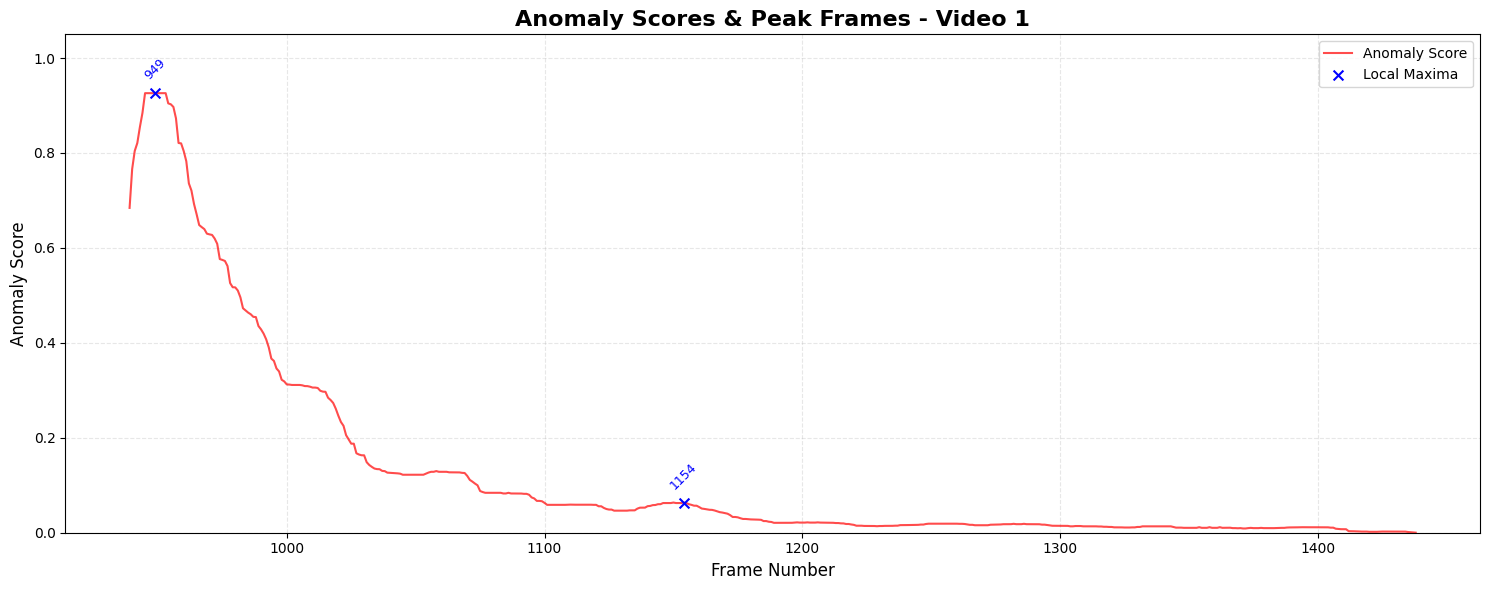

Found 20 maxima at frames: [   7   47  107  147  191  223  335  415  447  527  619  687  731  815
  899  935 1007 1081 1111 1151]


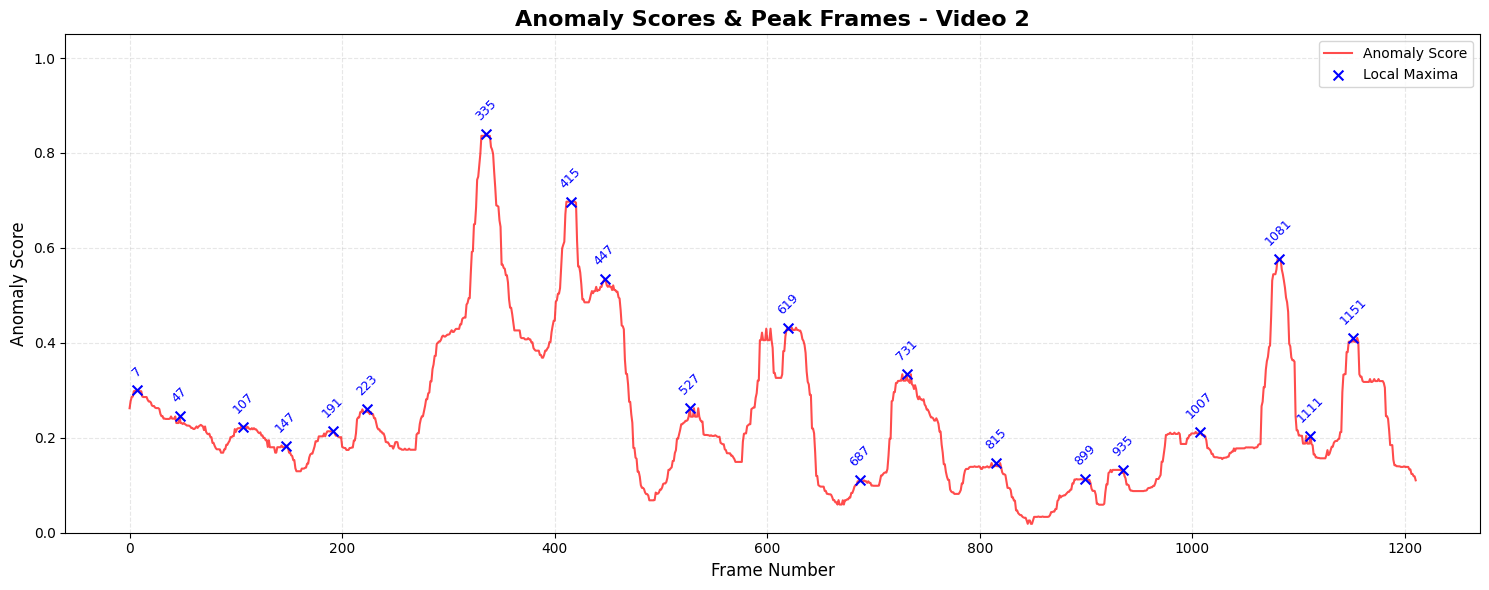

Found 14 maxima at frames: [205 253 321 353 405 501 533 565 609 645 729 777 846 912]


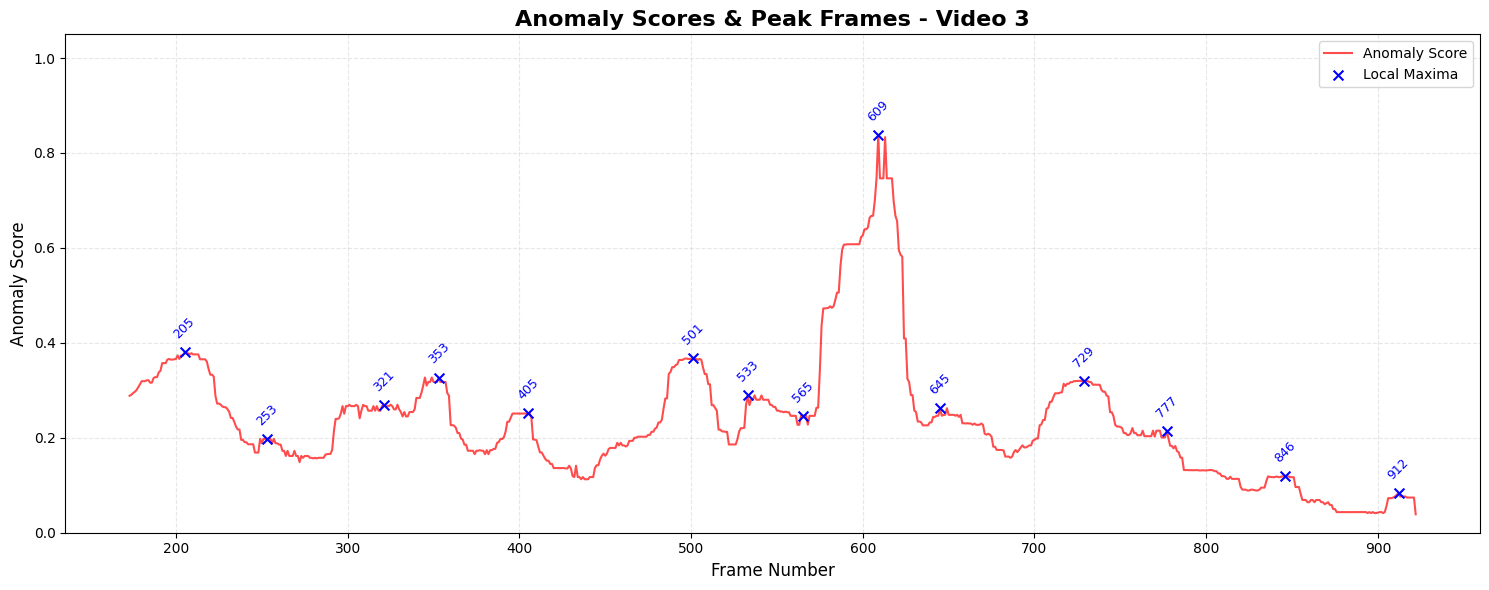

Found 17 maxima at frames: [  7  87 175 227 263 335 389 451 487 523 619 681 723 783 847 879 931]


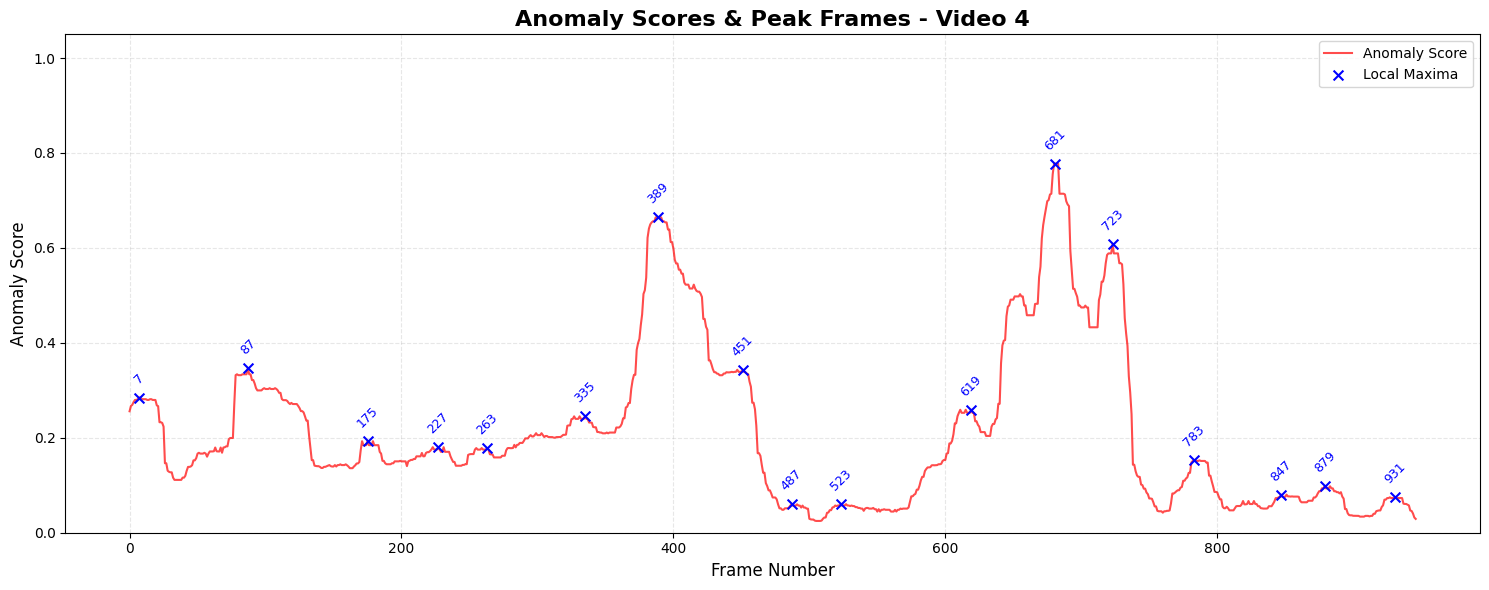

Found 17 maxima at frames: [ 43 107 151 195 255 387 427 461 491 522 553 607 651 705 767 935 991]


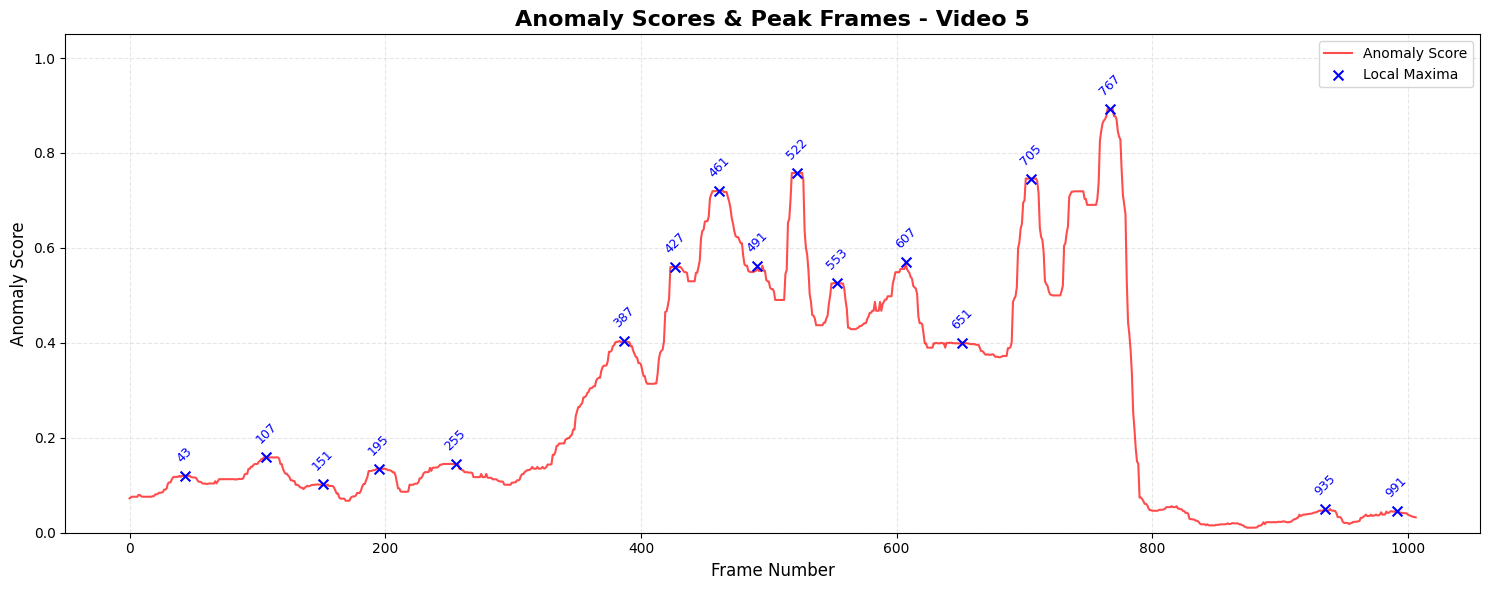

Found 9 maxima at frames: [ 668  728  822  880  928  971 1120 1164 1263]


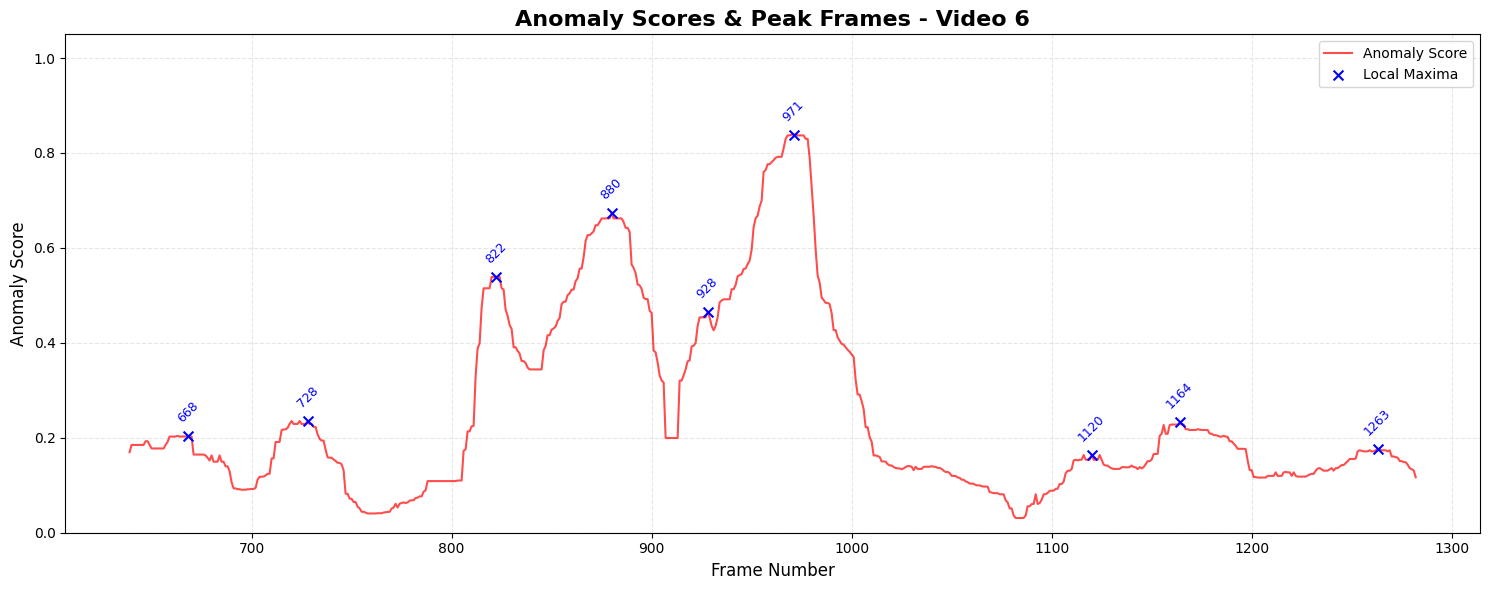

Found 9 maxima at frames: [ 55  87 151 183 227 332 364 472 584]


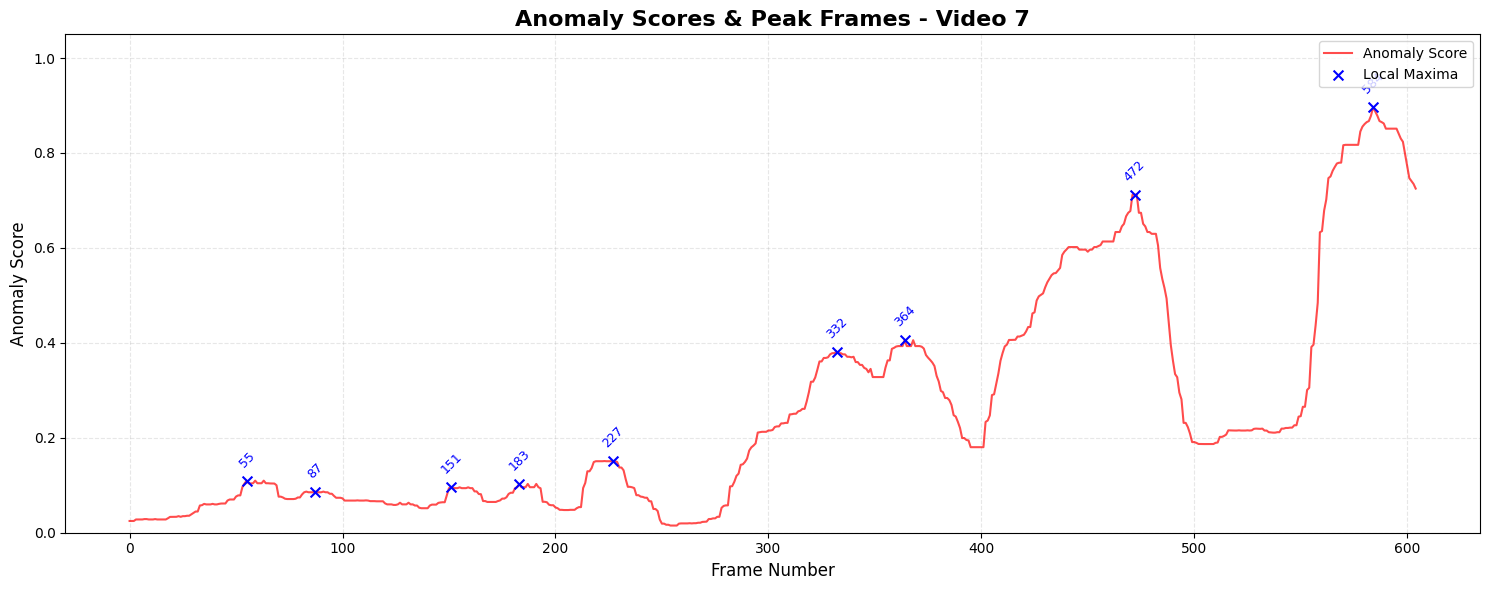

Found 2 maxima at frames: [ 1 31]


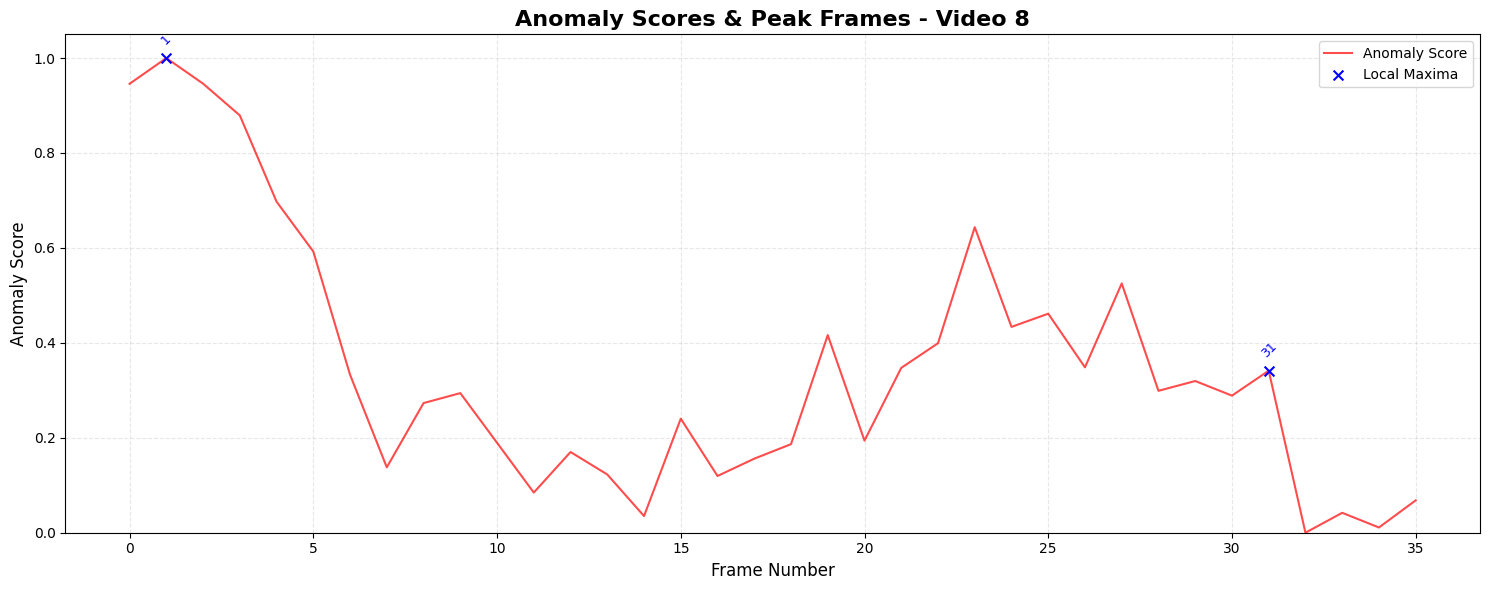

Found 6 maxima at frames: [ 27  59  91 159 247 328]


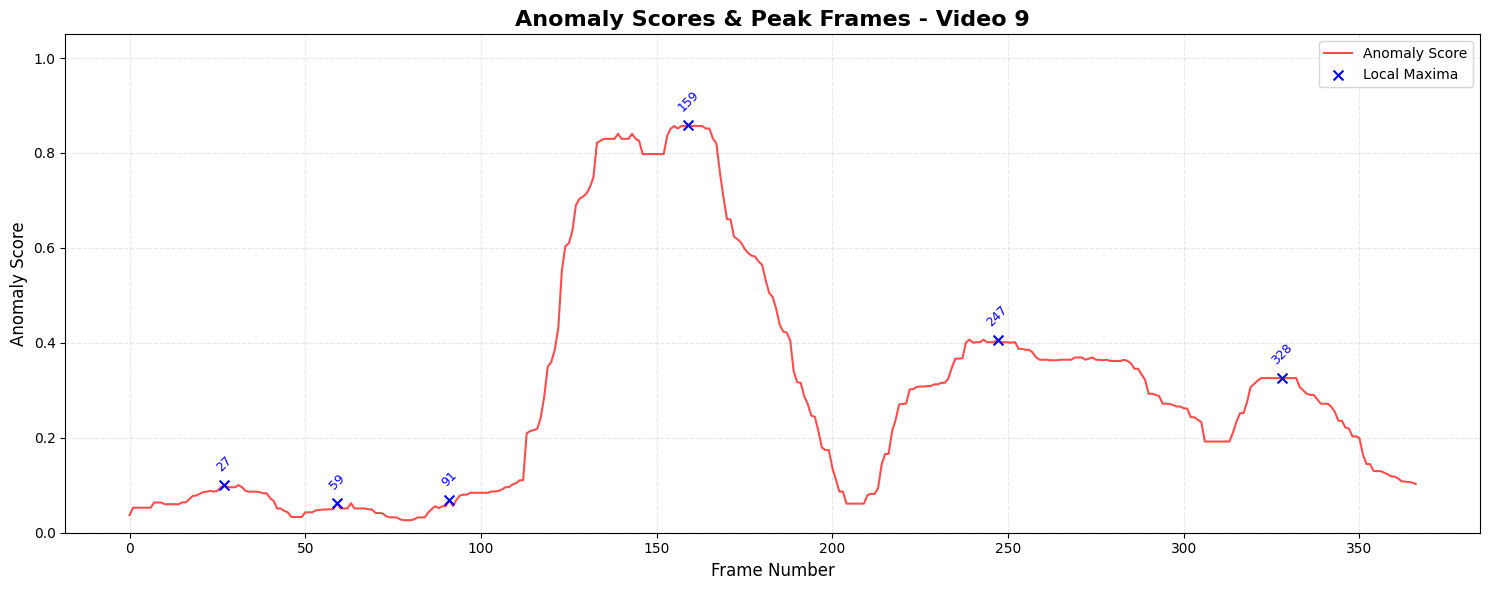

Found 12 maxima at frames: [111 170 263 299 351 391 447 508 573 622 688 785]


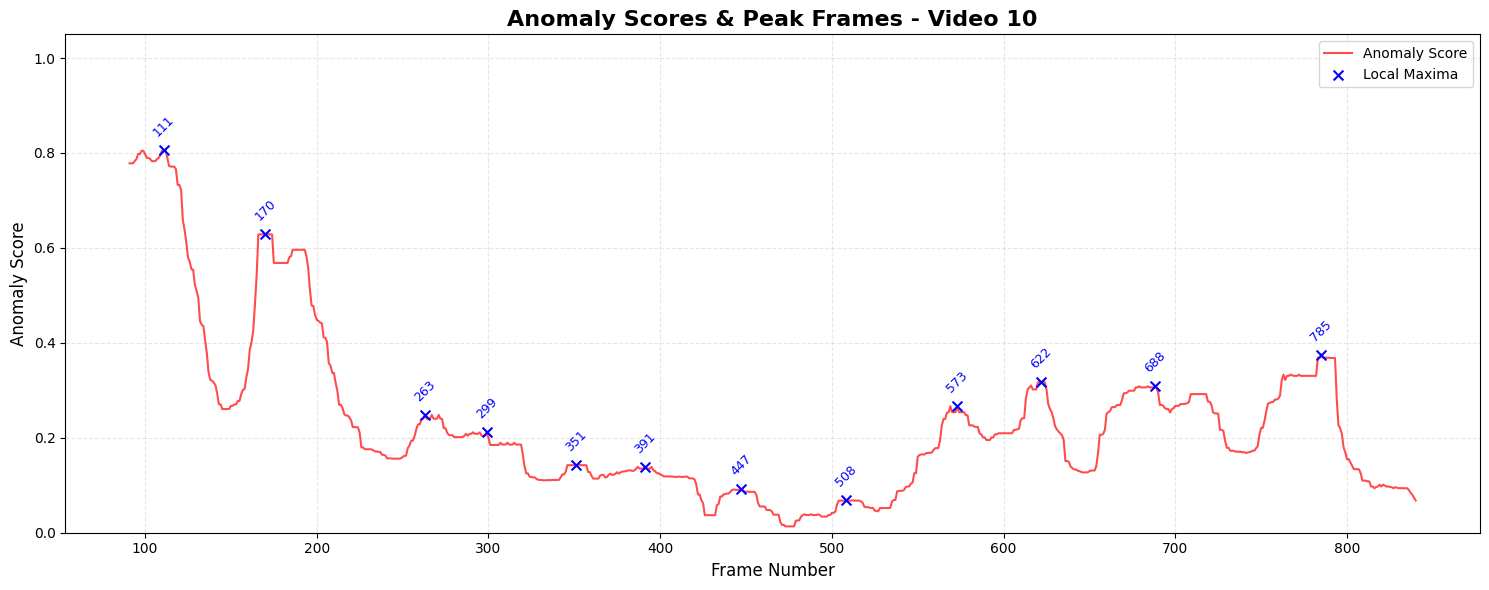

Found 8 maxima at frames: [ 23  57 127 159 203 323 379 431]


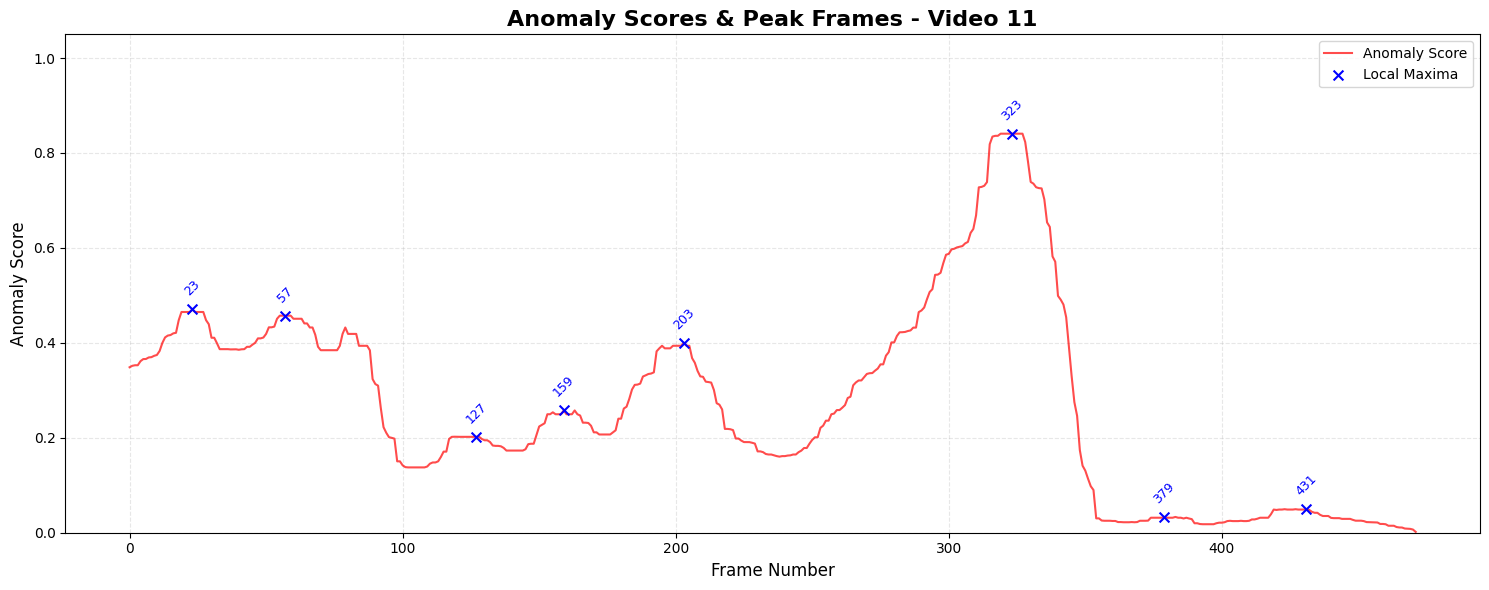

Found 12 maxima at frames: [ 579  611  677  713  765  838  870  910  999 1053 1215 1255]


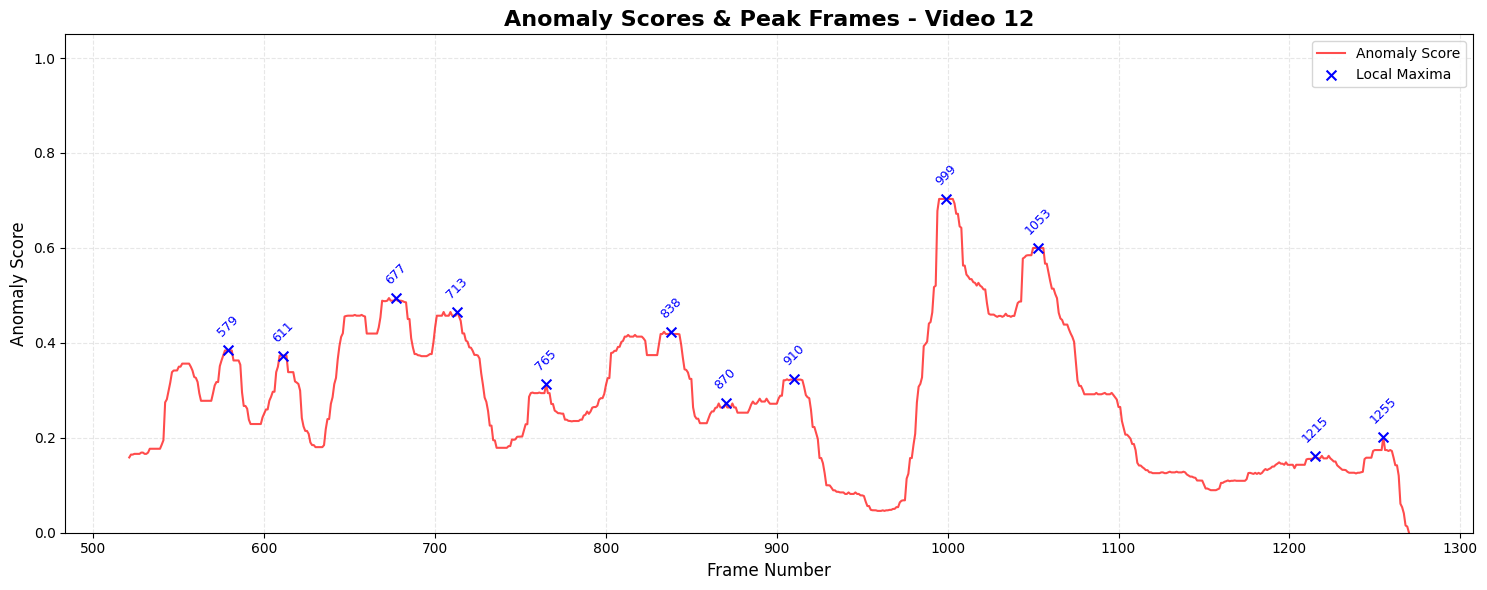

Found 5 maxima at frames: [ 55 231 267 446 484]


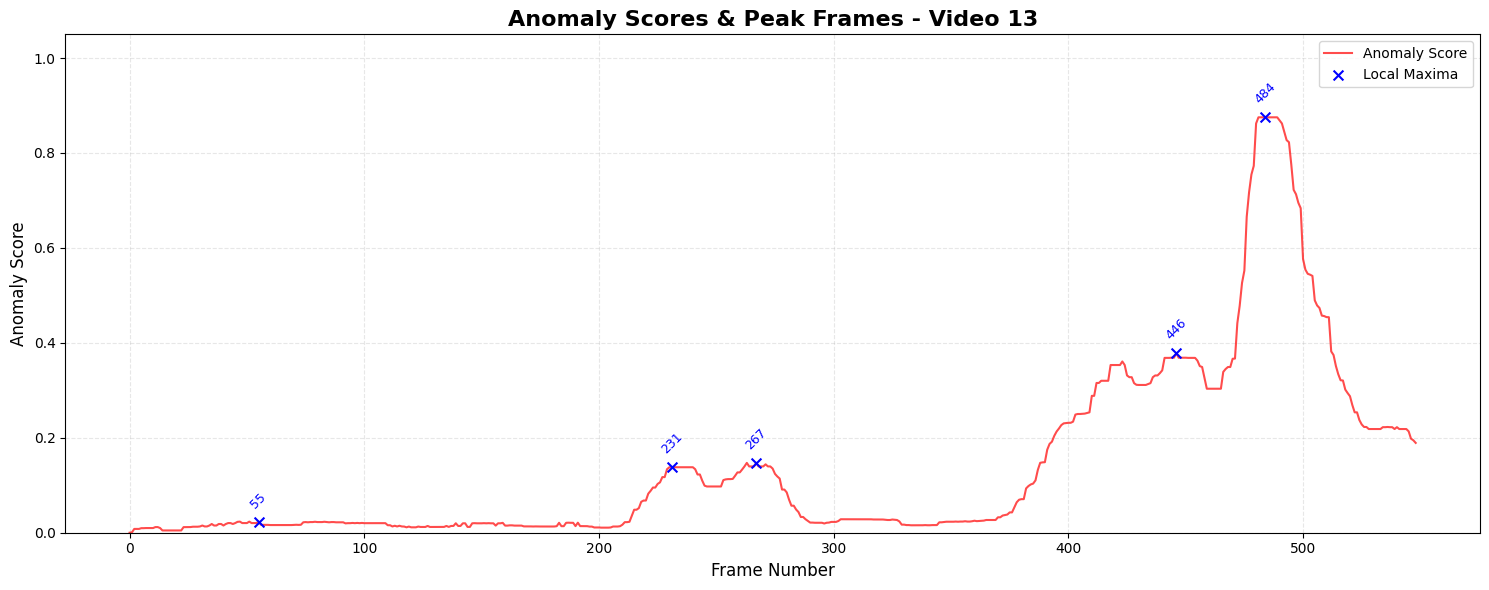

Found 6 maxima at frames: [ 23 139 315 367 436 498]


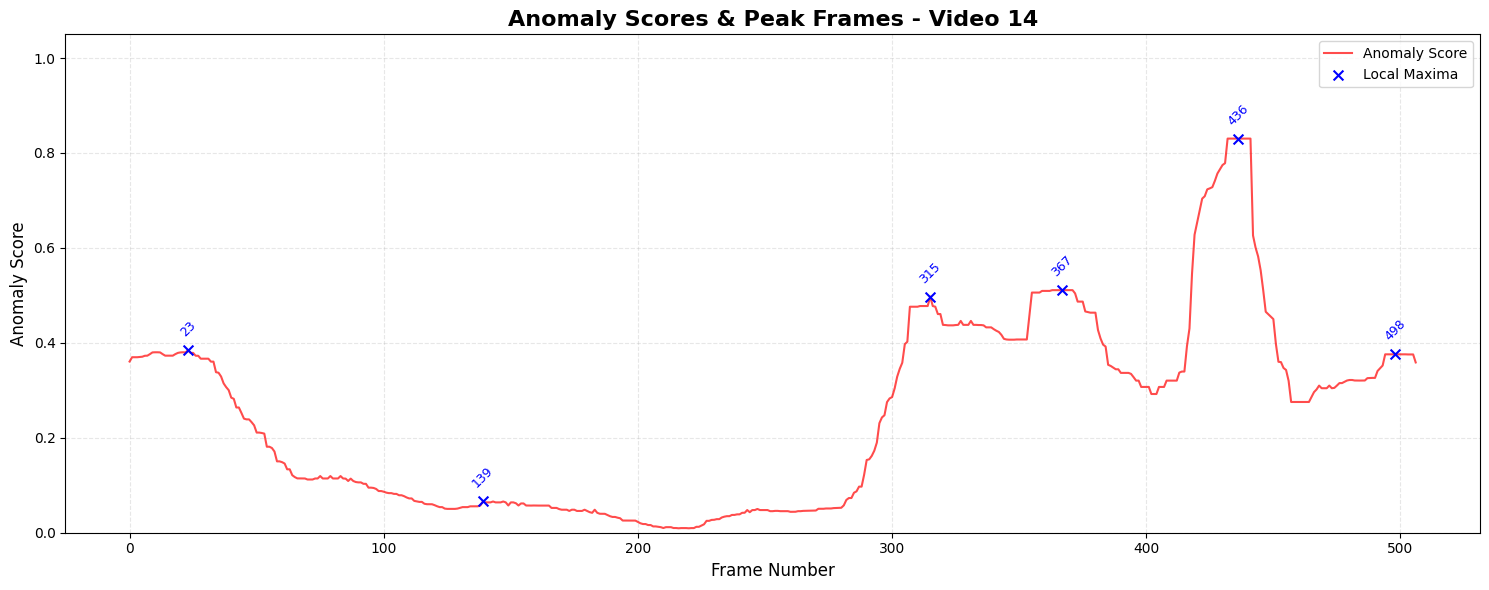

Found 10 maxima at frames: [282 318 382 528 626 675 736 780 849 920]


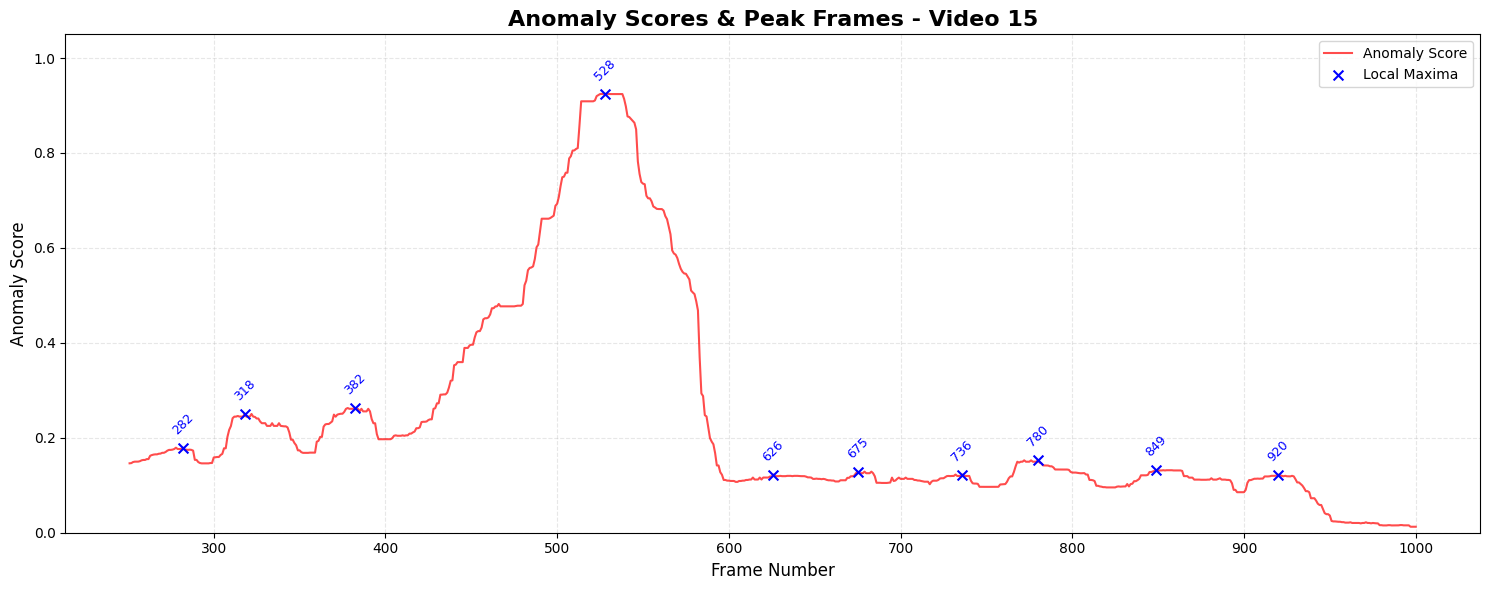

Found 3 maxima at frames: [ 71 479 733]


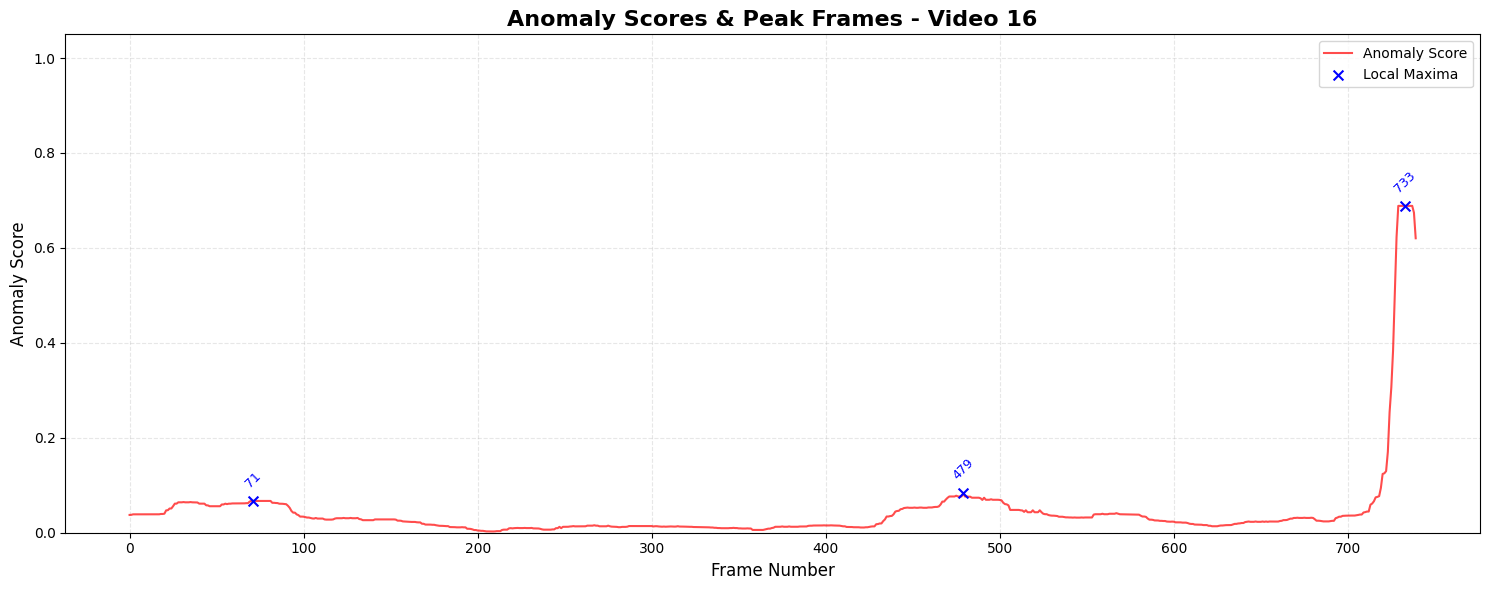

Found 7 maxima at frames: [ 23 124 163 220 268 358 412]


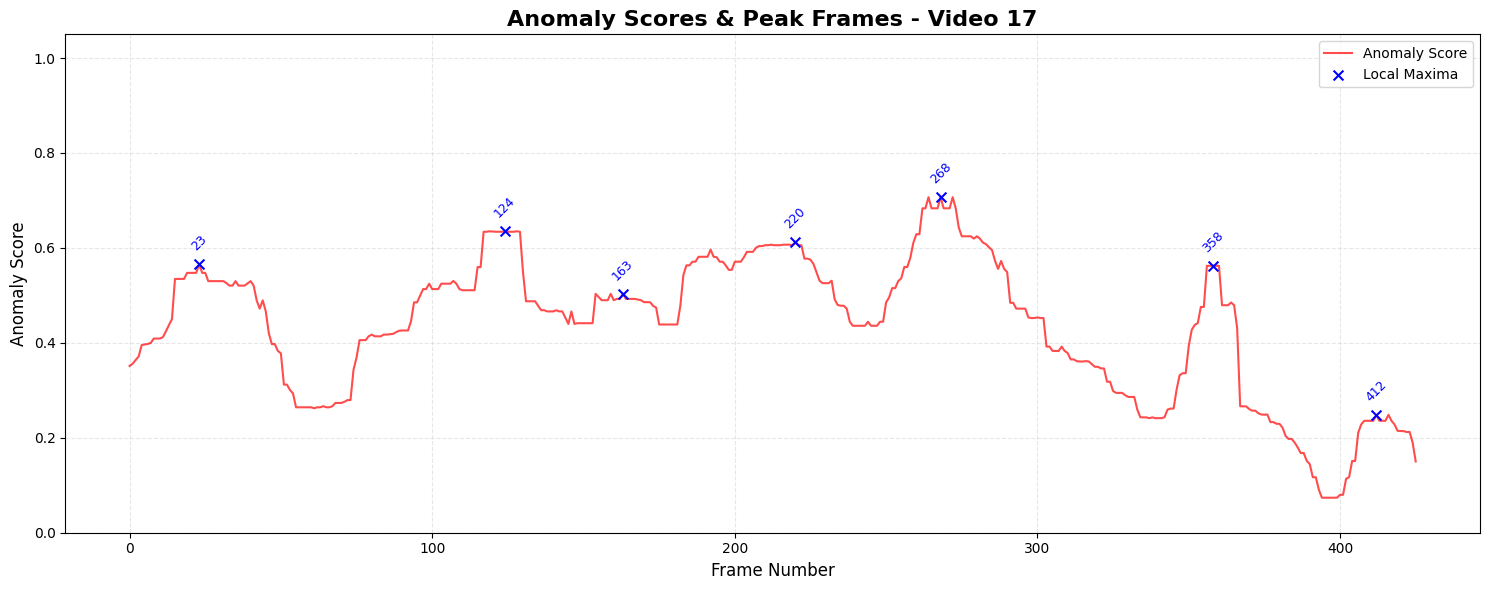

Found 7 maxima at frames: [ 33  79 112 157 196 231 285]


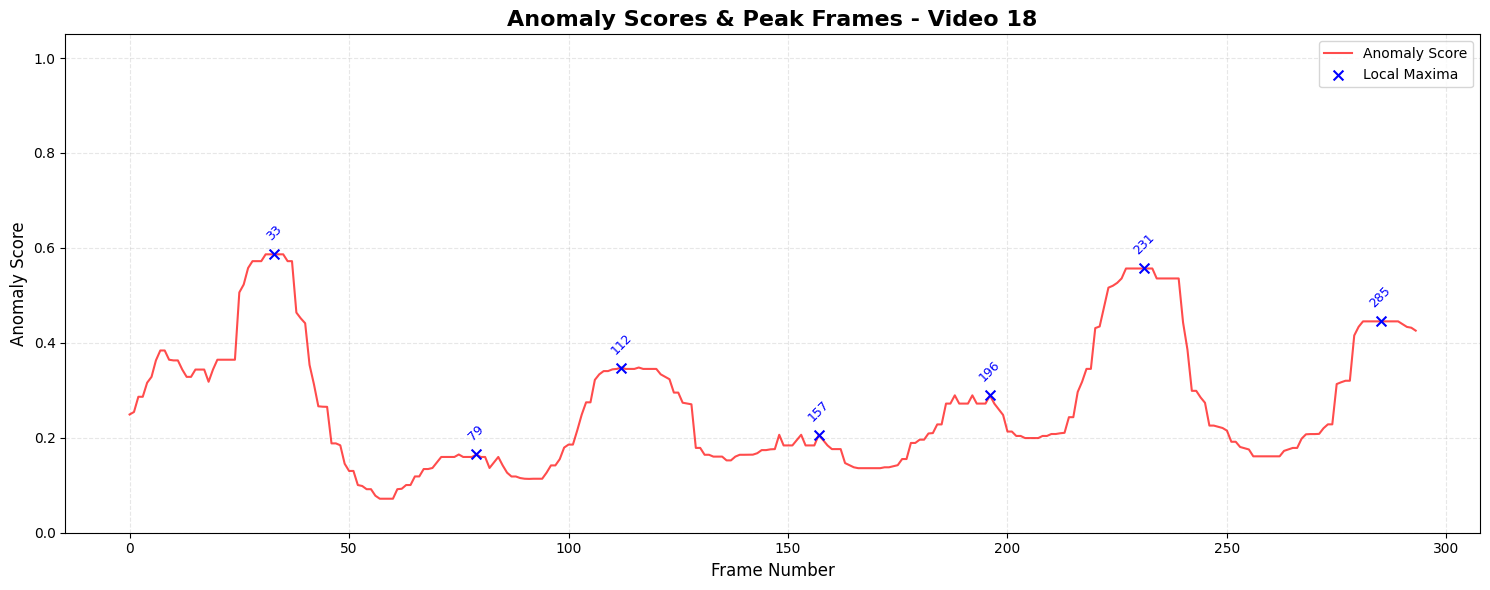

Found 5 maxima at frames: [ 40 104 147 190 242]


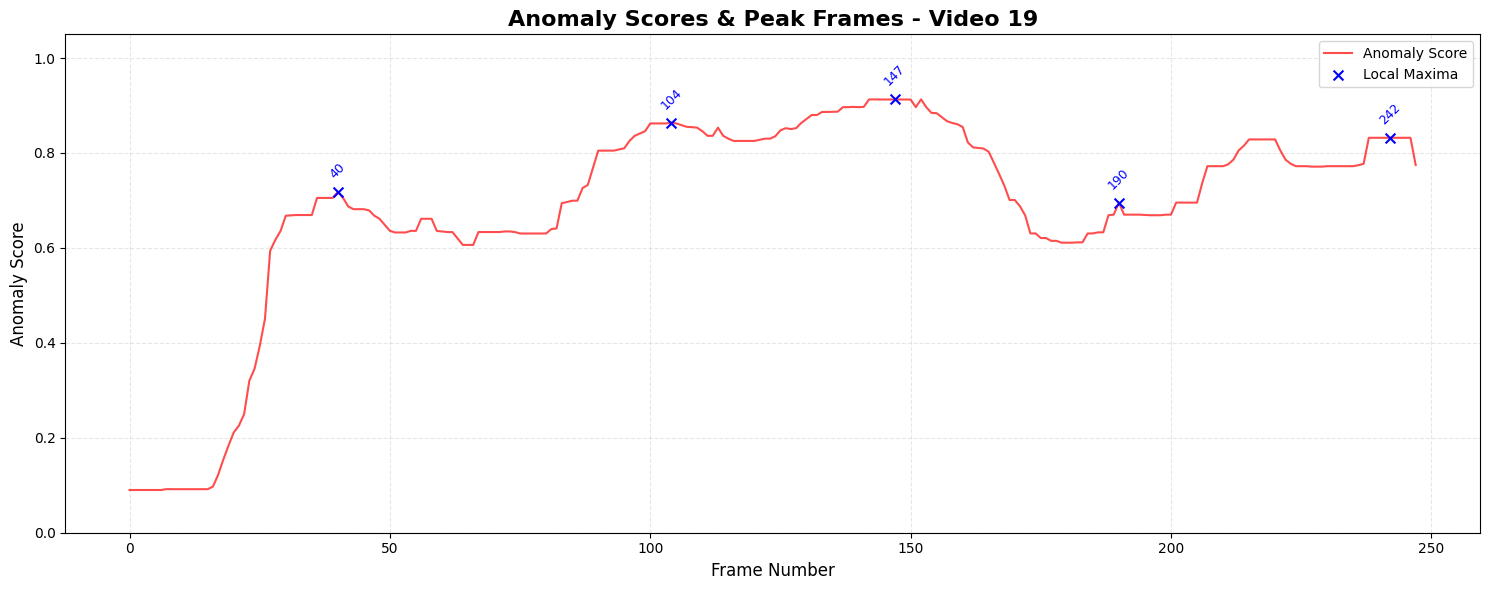

Found 3 maxima at frames: [100 215 255]


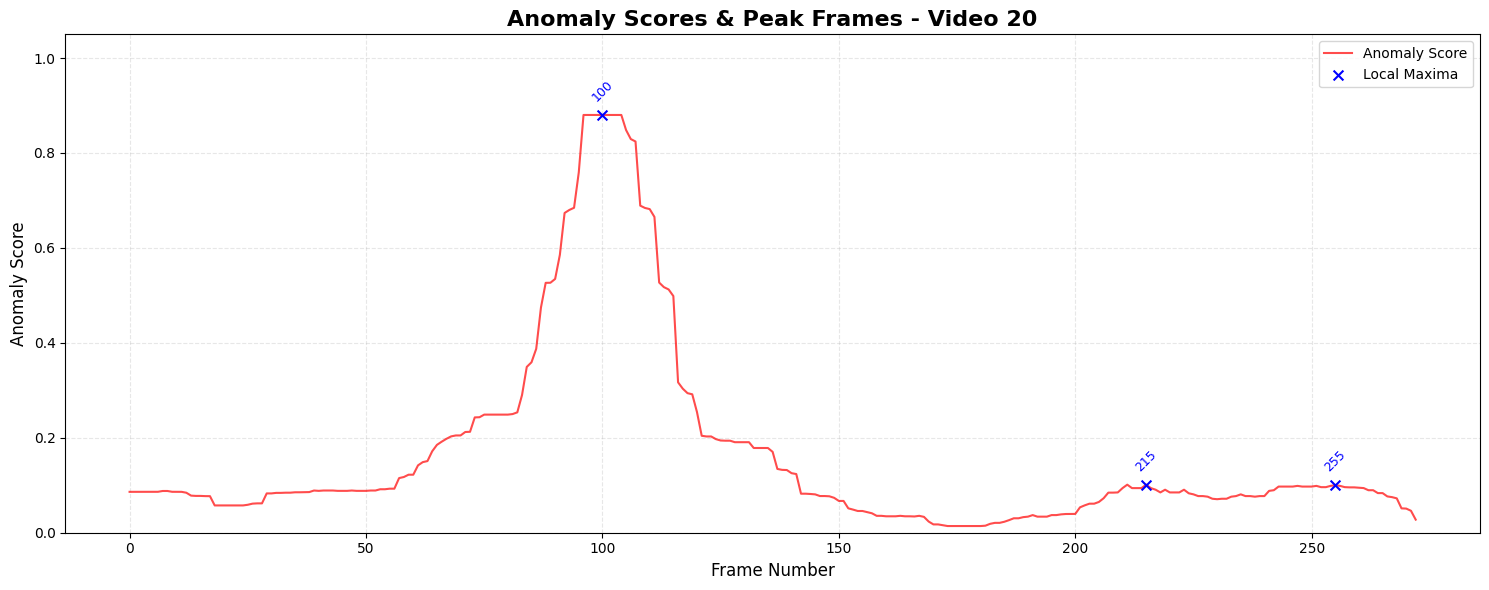

Found 2 maxima at frames: [ 8 43]


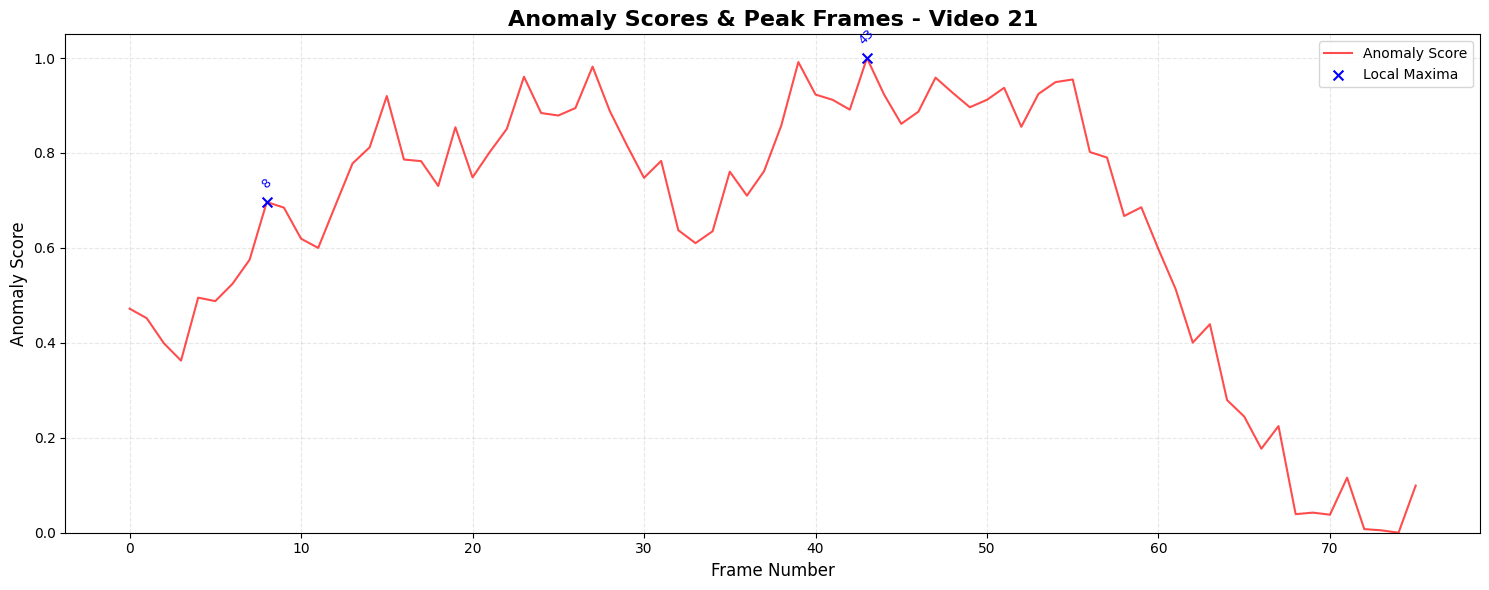

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

def plot_video_scores_with_maxima(csv_path, target_video_id, distance=15, prominence=0.05):
    # Plots the anomaly score vs Frame Number and highlights the local maxima.

    # csv_path: Path to the submission.csv file.
    # target_video_id: The integer ID of the video to plot.
    # distance: Minimum horizontal distance (in frames) between peaks.
    # prominence: Minimum vertical prominence of peaks. Helps ignore noise in flat regions.

    try:
        # 1. Load and Prepare Data
        df = pd.read_csv(csv_path)
        df[['vid', 'frame']] = df['Id'].str.split('_', expand=True).astype(int)

        video_data = df[df['vid'] == target_video_id].copy()

        if len(video_data) == 0:
            print(f"No data found for Video {target_video_id}")
            return

        video_data = video_data.sort_values(by='frame')

        # Extract series for easier handling
        frames = video_data['frame'].values
        scores = video_data['Predicted'].values

        # Find Local Maxima (Peaks)
        # distance: requires peaks to be separated by at least 'distance' frames
        # prominence: requires the peak to stand out from surrounding baseline

        peaks_indices, _ = find_peaks(scores, distance=distance, prominence=prominence)

        peak_frames = frames[peaks_indices]
        peak_scores = scores[peaks_indices]

        print(f"Found {len(peak_frames)} maxima at frames: {peak_frames}")

        # Plot
        plt.figure(figsize=(15, 6))

        # Main Line
        plt.plot(frames, scores, color='red', linewidth=1.5, alpha=0.7, label='Anomaly Score')

        # Maxima Markers
        plt.scatter(peak_frames, peak_scores, color='blue', s=50, marker='x', label='Local Maxima', zorder=5)

        # Plot Frame ID text above each peak marker
        for frame_id, score in zip(peak_frames, peak_scores):
            plt.annotate(f'{frame_id}',
                         xy=(frame_id, score),
                         xytext=(0, 10),
                         textcoords='offset points',
                         ha='center', fontsize=9, color='blue', rotation=45)

        plt.ylim(0, 1.05)

        # Formatting
        plt.title(f'Anomaly Scores & Peak Frames - Video {target_video_id}', fontsize=16, weight='bold')
        plt.xlabel('Frame Number', fontsize=12)
        plt.ylabel('Anomaly Score', fontsize=12)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"Error: The file '{csv_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


# Observe Anomaly Score Plots of all Videos

for video_id in range (1, 22):
    plot_video_scores_with_maxima('/content/out/submission_smoothed.csv', target_video_id=video_id, distance=30, prominence=0.01)


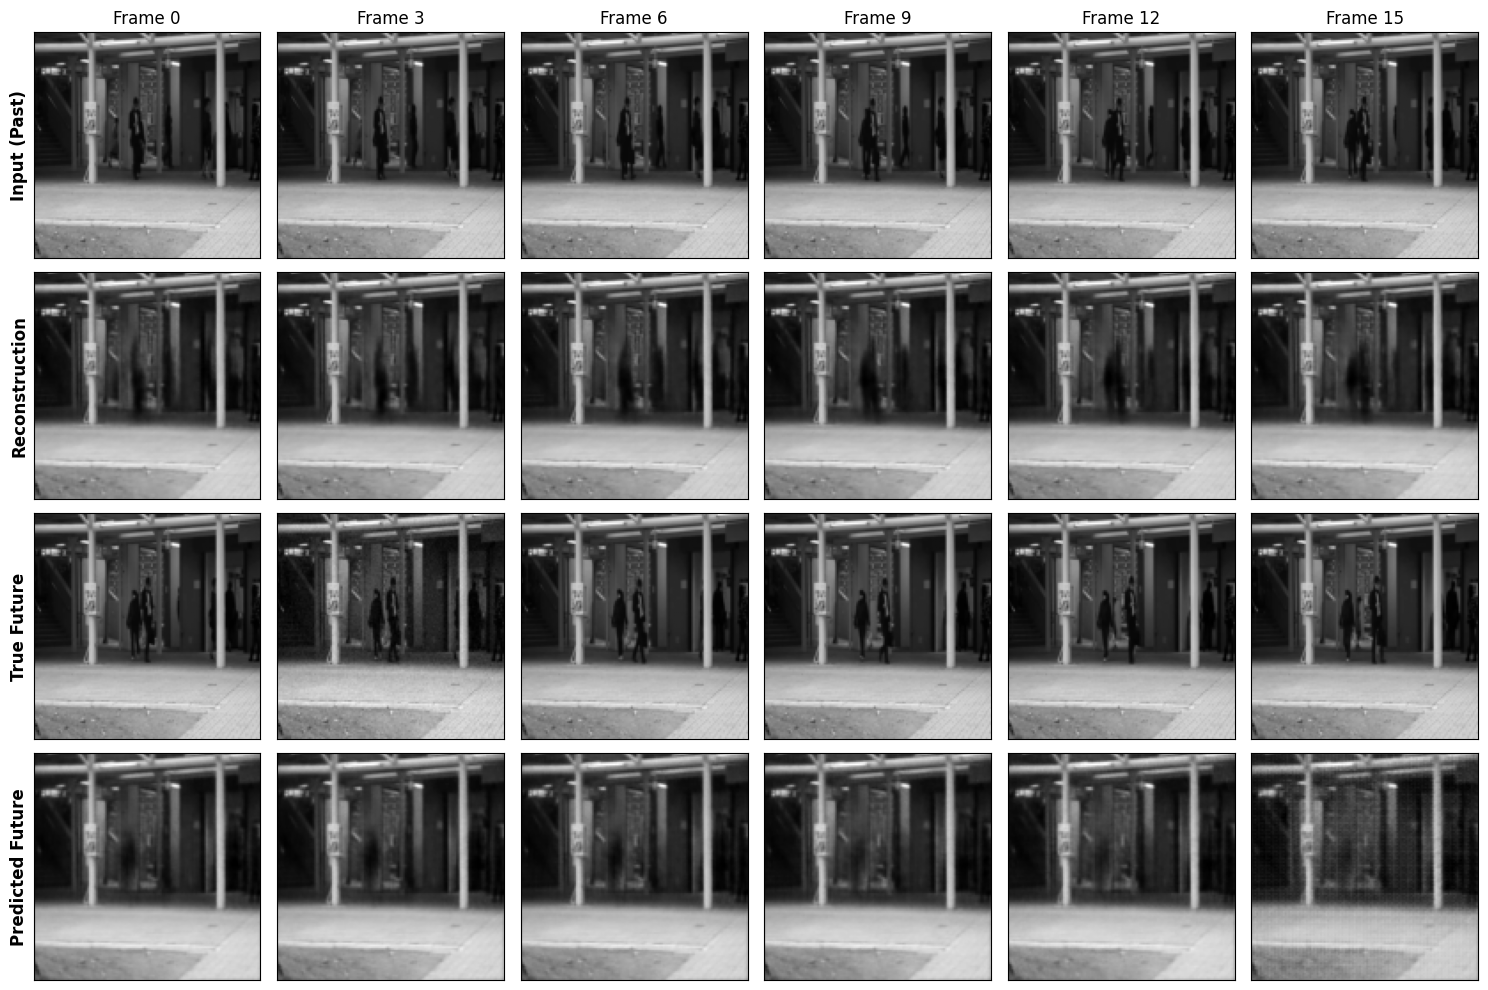

In [20]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def compare_clips(model, dataloader, num_frames_to_show=6):
    # Visualizes the Dual-Branch performance:
    # - Input vs Reconstruction
    # - True Future vs Predicted Future

    # Get a single batch
    device = next(model.parameters()).device
    iter_loader = iter(dataloader)

    for _ in range(40):
      batch_data = next(iter_loader)

    input_batch, future_batch, _, _, _ = batch_data

    # Run Inference
    model.eval()
    with torch.no_grad():
        input_batch = input_batch.to(device)
        recon_batch, pred_batch = model(input_batch)

    # Select the first clip in the batch and move to CPU
    # Shape: (C, T, H, W) -> e.g., (1, 16, 128, 128)
    input_clip = input_batch[0].cpu()
    recon_clip = recon_batch[0].cpu()
    future_clip = future_batch[0].cpu()
    pred_clip = pred_batch[0].cpu()

    #  Prepare indices for frames to plot
    total_frames = input_clip.shape[1]
    frame_indices = np.linspace(0, total_frames - 1, num_frames_to_show, dtype=int)

    # Setup Matplotlib Figure (4 Rows)
    fig, axes = plt.subplots(4, num_frames_to_show, figsize=(15, 10))

    # Row Labels
    rows = ["Input (Past)", "Reconstruction", "True Future", "Predicted Future"]
    for idx, ax_row in enumerate(axes[:, 0]):
        ax_row.set_ylabel(rows[idx], fontsize=12, weight='bold')

    # Plotting Loop
    for i, frame_idx in enumerate(frame_indices):

        # Helper to process tensor -> image
        def process(tensor, t_idx):
            img = tensor[:, t_idx, :, :] # (C, H, W)
            if img.shape[0] == 3:
                img = img.permute(1, 2, 0) # (H, W, C)
            else:
                img = img.squeeze() # Grayscale
            return img.clamp(0, 1).numpy() # Ensure strictly [0, 1]

        # Row 1: Input
        axes[0, i].imshow(process(input_clip, frame_idx), cmap='gray')
        axes[0, i].set_title(f"Frame {frame_idx}")

        # Row 2: Reconstruction
        axes[1, i].imshow(process(recon_clip, frame_idx), cmap='gray')

        # Row 3: True Future
        axes[2, i].imshow(process(future_clip, frame_idx), cmap='gray')

        # Row 4: Predicted Future
        axes[3, i].imshow(process(pred_clip, frame_idx), cmap='gray')

    # Clean up axes
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

test_transform = transforms.Compose([
      transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
      transforms.ToTensor(),
])

# 2. Load Data
dataset = TestingDataset(
    root_dir=TRAINING_DATA_DIR, # Run model on testing dataset to visualize reconstruction in test videos
    transform=test_transform,
    clip_len=16,
    stride=16
)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model = STAutoEncoder().to(DEVICE)
model.load_state_dict(torch.load('/content/st_autoencoder_epoch_40_final.pth'))
compare_clips(model, dataloader)

